In [1]:
import numpy as np 
import pandas as pd 
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from sklearn.metrics import plot_confusion_matrix

plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# good behavior for notebooks!
sns.set(context='notebook' , color_codes=True)
%matplotlib inline

# PHY 959: Homework Set #4
Due: **March 9, 2021**

___
***

# Problem 1:  Finding Higgs Bosons!!

In this homework assignment, you'll be exploring the use of Neural Networks (NNs) to study a represenative data sample from the search for the Higgs boson at the Large Hadron Collider (LHC).  In 2014, a machine learning challenge was posted to Kaggle to encourage data scientists across the world to try their hand(s) at searching for Higgs bosons in a simulated data sample.  The simulations were identical to the ones used by the ATLAS collaboration to search for Higgs bosons decaying to two tau leptons ($H \rightarrow \tau^+ \tau^-$).

Many people tried their best and after 6 months the contest ended.  Three winners were chosen by the contest judges and were awarded cash prizes, as well as an expense-paid trip to CERN:

1.  Gabor Melis : 7000 dollars
2.  Tim Salimans : 4000 dollars
3.  Pierre Courtiol (nhlx5haze) : 2000 dollars

You can find details about the challenge at the primary ATLAS site (https://higgsml.lal.in2p3.fr) and on Kaggle (https://www.kaggle.com/c/higgs-boson/).  The data sample consists of over 800k "events" that are a mixture of simulated $H \rightarrow \tau^+ \tau^-$ signal events with $M_{Higgs}=125$ GeV in addition to a range of non-Higgs "background" events (eg, $Z \rightarrow \tau^+ \tau^-$).  In this context, one event corresponds to a proton-proton collision at the LHC that was recorded by the ATLAS detector.  The signal-to-background ratio is roughly 0.0017, so the challenge is much like searching for a needle in a haystack! 

The data sample consists of 17 "primitive / PRI" features that correspond to the reconstructed observables in each event and 13 "derived / DER" features that are constructed from the primitive features using domain knowledge of the signal and background processes.  In addition, the are unique identifiers (Event ID) and sample weights that allow for converting from integer simulated events to the expected number of events to have been produced in the data sample.  The data sample and a detailed description of the features is provided here (http://opendata.cern.ch/record/328) and in even more detail here (http://opendata.cern.ch/record/329).  You are not expected to spend time learning the details, so this is for your own interest.

The contestants were given the first 250k events with labels ("s" and "b") to allow for training of a supervised learning classifier.  In addition, a second sample of 250k events **without** labels was provided as a way of testing for overtraining.  A third sample of ~300k events was withheld by the contest organizers as a blind validation sample to rank the contestants.  The ranking was performed by evaluating a metric called the "Approximate Median Significance", wherein a larger value corresponds to a more significant observation of Higgs boson production.  The submissions at the top of the leaderboards had AMS scores around 3.80.

<center> $AMS  = \sqrt{2\left( (s+b+10)\log\left(1+{s \over b+10}\right) -s \right)}$ </center>


Your challenge in homework set four will be to engage in the Higgs boson ML contest for yourself as a way to learn about NNs.  Your goal is to find the largest AMS score you can by making choices for your NN configuration.  You can choose to use the `scikit-learn`, `PyTorch` or `Keras+TensorFlow` frameworks.  You're welcome to use any optimization strategy you wish, but you should consider the following:

1. NN features: Editing your list of NN features can help reduce the training time and convergence efficiency.
2. NN layer architecture: The number of layers and the number of nodes per layer.
3. Choice of activation functions: With `PyTorch` and `Keras`, activations can be customized per layer.  With `scikit-learn`, you must choose one for the entire network.
4. Learning rate: The size of the steps used for your gradient descent optimization strategy.
5. Gradient descent strategy: The gradient descent optimizer can make a difference, but `Adam` is probably your best choice.
6. Batch size and cross validation: The batch size can greatly impact your convergence rate.
7. Dropout layers: The use of dropout can significantly reduce the chance of overtraining with large networks.
8. Regularization: L1 and L2 regularization are good choices to include, but the regularization strength can certainly be optimized.
9. Number of training epochs: The longer you train, the better your network will learn the data.  However, more epochs leads to longer training time and the possibility of overtraining.
10. Validation fraction: the fraction of your training data that is used in validation sets.

Together, these ten criteria comprise everything that would be required to perform an impressive optimization of the AMS score.  However, this is well beyond the scope of this course and the time you have to devote to this homework set.  Thus, you should use your intuition to:

1. Choose a subset of the criteria listed above.  I suggest to use 4, but more is fine.  **Don't be tempted to make very deep/wide networks, as it will train very slowly and cause you great consternation!**
2. Explain your optimization strategy.  How will you explore the hyper parameter space?  
3. Describe your results and the reasons that motivated your final choice.
4. Turn in code that yields your final submission and report your AMS score with that strategy.

This notebook sets up a simple NN using the `scikit-learn` Multilayer Perceptron and achieves an AMS score of 2.50 on a validation set.  Your goal is to improve over this score!

***
***

# Load the data sample

The first thing to do here is get the data sample (http://opendata.cern.ch/record/328).  Next you can load the data sample.  We will use the `pandas` `dataframe` class, as it's well suited to this task.  For the training sample, we will use the first 350k samples.  The remaining samples will be for validation and evaluation of independent AMS scores.

In [2]:
# read the first 350k samples
dataset=pd.read_csv('atlas-higgs-challenge-2014-v2.csv',nrows=350000)

# summarize the data

# shape
print("Shape:\n",dataset.shape, "\n")

# first 20 samples
#print("Head:\n",dataset.head(20), "\n")

# descriptions
#print("Description:\n",dataset.describe(), "\n")

# class distributio
print("Class Distribution:\n",dataset.groupby('Label').size())


Shape:
 (350000, 35) 

Class Distribution:
 Label
b    230043
s    119957
dtype: int64


# Now groom the data sample

We need prepare a subset of the sample on which to train.  We will remove all of the variables that should not be used in the training and retain the rest.  In addition, we'll keep a copy of the labels and weights for later.

In [3]:
# Make a new dataframe without some of the features
X = dataset.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weights = dataset['Weight'].values

# We'll find it useful to have the dataframe column names
colNames = X.columns

# Two forms of the 
y = pd.get_dummies(dataset.Label)
yt = y.values[:,0]

# Build selectors to separate our data in to signal and background
sSelector = np.array(yt == 0)
bSelector = np.array(yt == 1)

# Calculate what's in our samples
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966


# Build a neural network

Build and optimize your neural network.  As a starter reference, I've built a NN  using the Multilayer Perceptron class from `scikit-learn`.  This NN uses two hidden layers with 30 nodes each and I've limited the training to 50 epochs.  This will give you a first benchmark for our problem.  Your NN should do better than this!

In [4]:
clf = MLPClassifier(hidden_layer_sizes=(30,30),
                    random_state=1,verbose=True,max_iter=50)

clf.fit(X.values,yt)

Iteration 1, loss = 0.75008884
Iteration 2, loss = 0.50995339
Iteration 3, loss = 0.48288351
Iteration 4, loss = 0.47212986
Iteration 5, loss = 0.45717704
Iteration 6, loss = 0.44950489
Iteration 7, loss = 0.43699989
Iteration 8, loss = 0.42657355
Iteration 9, loss = 0.42092576
Iteration 10, loss = 0.41395010
Iteration 11, loss = 0.40920209
Iteration 12, loss = 0.40325465
Iteration 13, loss = 0.40076032
Iteration 14, loss = 0.39724979
Iteration 15, loss = 0.39578745
Iteration 16, loss = 0.39416526
Iteration 17, loss = 0.39247134
Iteration 18, loss = 0.39010099
Iteration 19, loss = 0.38954302
Iteration 20, loss = 0.38846460
Iteration 21, loss = 0.38685794
Iteration 22, loss = 0.38685471
Iteration 23, loss = 0.38625962
Iteration 24, loss = 0.38591950
Iteration 25, loss = 0.38494399
Iteration 26, loss = 0.38462950
Iteration 27, loss = 0.38322788
Iteration 28, loss = 0.38387160
Iteration 29, loss = 0.38260021
Iteration 30, loss = 0.38228239
Iteration 31, loss = 0.38160827
Iteration 32, los

/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=50, random_state=1,
              verbose=True)

In [5]:
def plotNNresults(predictions,sSelector,bSelector,weights):
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[0],doNorm=False)
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[1],doNorm=True,b_weight=weights[bSelector],s_weight=weights[sSelector])
    plt.show()
    
    class_names = ['Signal','Background']
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    plt.rcParams.update({'font.size': 22})
    disp = plot_confusion_matrix(clf, X.values, yt, display_labels=class_names,normalize='true',ax=ax[0])
    ax[0].set_title("Unweighted")
    plt.grid(False)

    disp = plot_confusion_matrix(clf, X.values, yt, display_labels=class_names,normalize='true',ax=ax[1],sample_weight=weights)
    ax[1].set_title("Weighted")
    plt.grid(False)
    plt.show()

def plotHisto(sig,bkg,label,ax, doNorm=True, s_weight=None, b_weight=None):
    trange = [0,1]
    
    sweight = None
    bweight = None
    if doNorm == True:
        sweight = s_weight
        bweight = b_weight
    
    sVals, edges = np.histogram(sig,bins=100,range=trange,weights=sweight)
    bVals, edges = np.histogram(bkg,bins=100,range=trange,weights=bweight)
    xvals = np.linspace(trange[0],trange[1],100)
    
    if doNorm:
        ax.plot(xvals,sVals/np.sum(sVals),label="Signal")
        ax.plot(xvals,bVals/np.sum(bVals),label="Bkgd")
        ax.set_title("{}, Normalized".format(label))
    else:
        ax.plot(xvals,sVals,label="Signal")
        ax.plot(xvals,bVals,label="Bkgd")
        ax.set_title("{}, Unnormalized".format(label))
    ax.set_ylim(bottom=0)
    ax.legend()

# Now let's plot our NN results

We'll first pull the score (overall accuracy) and then plot the NN output values as well as the confusion matrix.  Note that we get somewhat different results for the cases in which we weight our events.  If you're using `PyTorch` or `Keras`, you may need to edit the plotting functions and score/accuracy methods.

Unweighted score:  0.8306885714285714
Weighted score:  0.9132970403742938
Prediction array structure:
 [[0.54158619 0.45841381]
 [0.19935111 0.80064889]
 [0.15341239 0.84658761]
 [0.09766763 0.90233237]
 [0.03118251 0.96881749]
 [0.13665843 0.86334157]
 [0.39670389 0.60329611]
 [0.93199401 0.06800599]
 [0.17974433 0.82025567]
 [0.60694135 0.39305865]]


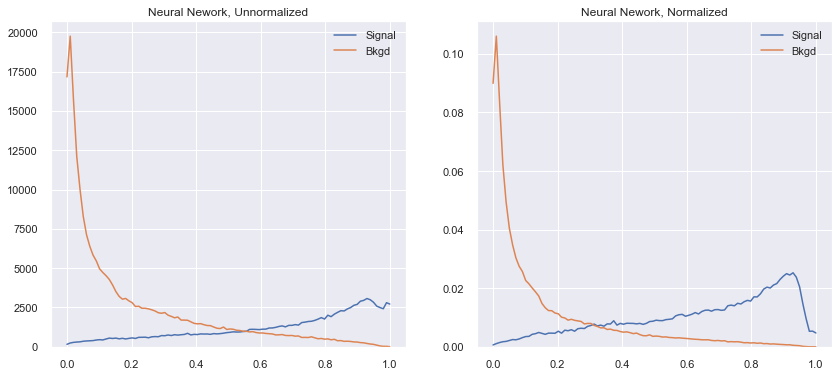

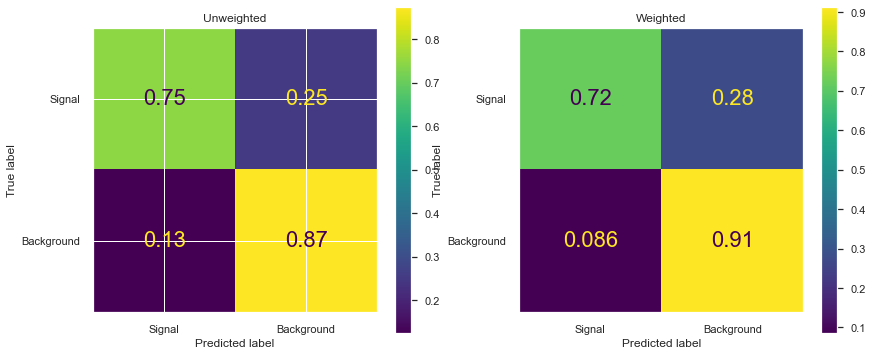

In [6]:
print("Unweighted score: ", clf.score(X.values,yt))
print("Weighted score: ",clf.score(X.values,yt,weights))

predictions = clf.predict_proba(X.values)

print("Prediction array structure:\n",predictions[:10])

plotNNresults(predictions,sSelector,bSelector,weights) 


In [7]:
def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0
    
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

def plotAMS(X,y,weights):
    # order them 
    sSelector = np.array(y == 0)
    bSelector = np.array(y == 1)
    
    permute = X.argsort()
    sSelector = sSelector[permute]
    bSelector = bSelector[permute]
    X = X[permute]
    weights = weights[permute]

    # pick out only the signal values
    sVals = X[sSelector]
    sigW = weights[sSelector]

    # pick out only the background values
    bVals = X[bSelector]
    bkgW = weights[bSelector]

    # make arrays
    xvals = np.linspace(0,1,100)
    amsV = np.linspace(0,1,100)
    bkgFrac = np.linspace(0,1,100)
    aIdx = 0

    # We are going to organize by background rejection fraction,
    # so we need to find those values
    for xx in xvals:
        idxS = bisect.bisect_left(sVals,xx)
        idxB = bisect.bisect_left(bVals,xx)
        amsV[aIdx] = ams(np.sum(sigW[idxS:]),np.sum(bkgW[idxB:]))
        bkgFrac[aIdx] = 1-np.sum(bkgW[idxB:])/np.sum(bkgW)
        aIdx += 1

    permute = bkgFrac.argsort()
    bkgFrac = bkgFrac[permute]
    amsV = amsV[permute]

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(bkgFrac*100,amsV)
    ax.set_xlabel("Background rejection (%)")
    ax.set_ylabel("AMS Score")
    plt.show()
    print("Maximum AMS Value: ",np.max(amsV))

# Finally, let's check to see how we did for our challenge

The challenge was "judged" based on the Approximate Mean Significance (AMS) score.  Let's just quickly check how we did with new "blind" data.  To get the blind data, we'll use the remaining 468k events from our file.  Remember the best work in the Higgs ML challenge achieved an AMS score of ~ 3.80.

Shape:
 (468239, 35) 



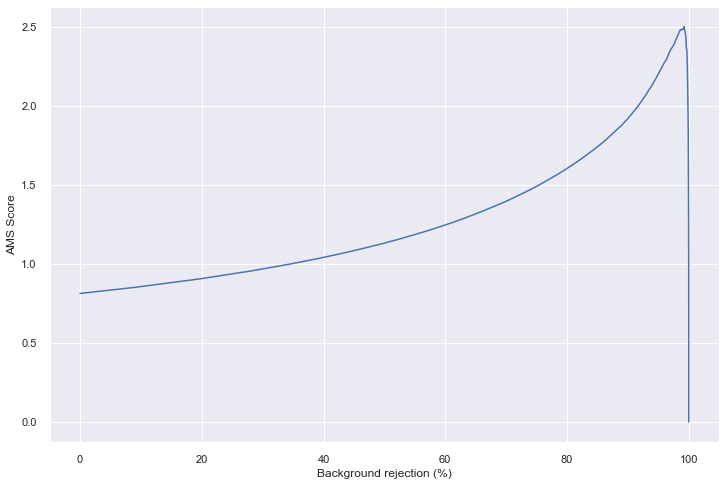

Maximum AMS Value:  2.5004051692046185


In [8]:
# read the first last ~468k samples
datasetVal=pd.read_csv('atlas-higgs-challenge-2014-v2.csv',skiprows = range(1, 350000))

# shape
print("Shape:\n",datasetVal.shape, "\n")

# Make a new dataframe without some of the features
Xval = datasetVal.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weightsVal = datasetVal['Weight'].values

# Two forms of the labels
y = pd.get_dummies(datasetVal.Label)
yVal = y.values[:,0]

# Evaluate our new data with the NN
predictions = clf.predict_proba(Xval.values)

# Plot the AMS scores
plotAMS(predictions[:,0],yVal,weightsVal)
